In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width: 98% !important }</style>'))

In [2]:
from utilities import *

In [3]:
import joblib
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
from sklearn.preprocessing import normalize
import seaborn as sns

sns.set()

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Import Data

In [5]:
pin = read_pin('../Data/pin.csv')
test_pin = read_pin('../Data/testPin.csv')
ble = read_ble('../Data/ble.csv')

In [6]:
data_1 = read_data('../Data/rssi5.csv')
data_2 = read_data('../Data/rssi_2.csv')

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [7]:
test_1 = read_data('../Data/testRssi.csv')
test_2 = read_data('../Data/testRssi_2.csv')

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [8]:
data = pd.concat([data_1, data_2], axis=0)
test = pd.concat([test_1, test_2], axis=0)

In [9]:
test.shape

(27229, 19)

## Train Validation Split

In [10]:
train, validation = train_validation_split(data)

In [11]:
print(train.shape)
print(validation.shape)

(102033, 19)
(11337, 19)


In [12]:
def linear_impute(data):
    for s in scanners:
        dx = data['X'] - ble[s]['X']
        dy = data['Y'] - ble[s]['Y']
        d = np.sqrt(np.square(dy) + np.square(dx))
        reg = joblib.load('../Models/linear_distance_models_2/{}.joblib'.format(s))
        ss = pd.Series(reg.predict(d.values.reshape((-1, 1))))
        data[s].fillna(ss, inplace=True)

def impute(data):
    rolling_win = 10

    data = data.sort_values("time")
    data_grouped = data.set_index('time').groupby([pd.Grouper('location'), pd.Grouper(freq='100ms')]).mean().reset_index()
    data_rolled = data_grouped.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()
    data_imputed = data_rolled.set_index("location").groupby("location").ffill().reset_index()
    data_imputed["X"] = data_imputed["location"].apply(lambda x: pin[x]["X"] if x[0] == 'V' else test_pin[x]["X"])
    data_imputed["Y"] = data_imputed["location"].apply(lambda x: pin[x]["Y"] if x[0] == 'V' else test_pin[x]["Y"])
    linear_impute(data_imputed)
    return data_imputed

In [13]:
train_imputed = impute(train)
validation_imputed = impute(validation)
test_imputed = impute(test)

In [14]:
train_imputed[scanners] = normalize(train_imputed[scanners] + 100, norm='l1')
validation_imputed[scanners] = normalize(validation_imputed[scanners] + 100, norm='l1')
test_imputed[scanners] = normalize(test_imputed[scanners] + 100, norm='l1')

In [15]:
train_imputed

,location,level_1,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,...,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C,X,Y
0,V1_10,0,0.069843,0.060182,0.054485,0.091165,0.072630,0.049890,0.047825,0.073477,...,0.053449,0.029226,0.079214,0.091991,0.065755,0.056412,0.011301,0.071719,11.17660,5.29753
1,V1_10,1,0.083750,0.059282,0.053671,0.089802,0.071544,0.049144,0.047110,0.072379,...,0.052650,0.028789,0.078030,0.090616,0.064772,0.055568,0.011132,0.070647,11.17660,5.29753
2,V1_10,2,0.083776,0.059300,0.053687,0.089829,0.071565,0.049159,0.047124,0.072401,...,0.052666,0.028798,0.078054,0.090321,0.064791,0.055585,0.011136,0.070686,11.17660,5.29753
3,V1_10,3,0.083232,0.058915,0.053339,0.089246,0.071101,0.048840,0.046818,0.067626,...,0.058523,0.028611,0.077547,0.089735,0.064371,0.059823,0.011063,0.070227,11.17660,5.29753
4,V1_10,4,0.083453,0.060328,0.054618,0.091387,0.072807,0.050605,0.035956,0.062590,...,0.060592,0.029297,0.069249,0.091887,0.065915,0.061258,0.011329,0.077239,11.17660,5.29753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48776,V1_9,48776,0.073244,0.037369,0.056801,0.086697,0.044843,0.026906,0.059791,0.110613,...,0.047833,0.026906,0.080717,0.071749,0.085202,0.062780,0.017937,0.098655,8.17867,5.28213
48777,V1_9,48777,0.073134,0.037313,0.056716,0.086567,0.044776,0.026866,0.059701,0.110448,...,0.053731,0.026866,0.080597,0.071642,0.095522,0.047761,0.017910,0.098507,8.17867,5.28213
48778,V1_9,48778,0.074468,0.030395,0.057751,0.074468,0.045593,0.027356,0.060790,0.112462,...,0.054711,0.027356,0.082067,0.075988,0.097264,0.048632,0.018237,0.100304,8.17867,5.28213
48779,V1_9,48779,0.074355,0.030349,0.057663,0.066768,0.045524,0.033384,0.060698,0.112291,...,0.054628,0.027314,0.084977,0.075873,0.097117,0.048558,0.018209,0.100152,8.17867,5.28213


## Model Training

In [16]:
X_train, y_train = train_imputed[scanners].values, train_imputed[["X", "Y"]].values
X_validation, y_validation = validation_imputed[scanners].values, validation_imputed[["X", "Y"]].values
X_test, y_test = test_imputed[scanners].values, test_imputed[["X", "Y"]].values

In [17]:
optimizer = tf.keras.optimizers.RMSprop(0.00001)
loss = "mse"
metrics = ["mae", "mse"]
batch_size = 32
epochs = 10000

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_loss')
]

inputs = tf.keras.Input(shape=(17,))

stats = tf.keras.layers.Dense(8, activation='relu')(inputs)

features = tf.keras.layers.Concatenate(axis=1)([stats, inputs])

x = tf.keras.layers.Dense(128, activation='relu')(features)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(1)(x)

y = tf.keras.layers.Dense(128, activation='relu')(features)
y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
y = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
y = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
y = tf.keras.layers.Dense(1)(y)

outputs = tf.keras.layers.Concatenate(axis=1)([x, y])

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 8)            144         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 25)           0           dense[0][0]                      
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          3328        concatenate[0][0]            

In [19]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Train on 48781 samples, validate on 11680 samples
Epoch 1/10000
48781/48781 [==============================] - 6s 122us/sample - loss: 213.6868 - mae: 12.5878 - mse: 210.9100 - val_loss: 210.9215 - val_mae: 12.6978 - val_mse: 208.3544
Epoch 2/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 199.0457 - mae: 11.9522 - mse: 196.6666 - val_loss: 188.0146 - val_mae: 11.6859 - val_mse: 185.8089
Epoch 3/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 166.5362 - mae: 10.3157 - mse: 164.4760 - val_loss: 142.6797 - val_mae: 9.2962 - val_mse: 140.7519
Epoch 4/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 115.2809 - mae: 7.5736 - mse: 113.4604 - val_loss: 85.1527 - val_mae: 6.4098 - val_mse: 83.4379
Epoch 5/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 62.1207 - mae: 5.4311 - mse: 60.5026 - val_loss: 37.7701 - val_mae: 4.5811 - val_mse: 36.2376
Epoch 6/10000
48781/48781 [=============

48781/48781 [==============================] - 2s 35us/sample - loss: 3.0881 - mae: 1.1317 - mse: 2.1723 - val_loss: 3.5565 - val_mae: 1.3181 - val_mse: 2.6433
Epoch 48/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 3.0747 - mae: 1.1294 - mse: 2.1646 - val_loss: 3.5227 - val_mae: 1.3145 - val_mse: 2.6157
Epoch 49/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 3.0608 - mae: 1.1266 - mse: 2.1566 - val_loss: 3.5230 - val_mae: 1.3161 - val_mse: 2.6220
Epoch 50/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 3.0485 - mae: 1.1244 - mse: 2.1498 - val_loss: 3.5099 - val_mae: 1.3115 - val_mse: 2.6139
Epoch 51/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 3.0357 - mae: 1.1218 - mse: 2.1423 - val_loss: 3.5013 - val_mae: 1.3114 - val_mse: 2.6105
Epoch 52/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 3.0237 - mae: 1.1196 - mse: 2.1353 - val_loss: 3.5001 -

Epoch 94/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 2.6184 - mae: 1.0233 - mse: 1.8552 - val_loss: 3.2820 - val_mae: 1.2855 - val_mse: 2.5197
Epoch 95/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 2.6109 - mae: 1.0213 - mse: 1.8493 - val_loss: 3.2519 - val_mae: 1.2744 - val_mse: 2.4912
Epoch 96/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 2.6029 - mae: 1.0192 - mse: 1.8431 - val_loss: 3.2785 - val_mae: 1.2855 - val_mse: 2.5194
Epoch 97/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 2.5948 - mae: 1.0169 - mse: 1.8363 - val_loss: 3.2576 - val_mae: 1.2808 - val_mse: 2.5001
Epoch 98/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 2.5868 - mae: 1.0146 - mse: 1.8297 - val_loss: 3.2692 - val_mae: 1.2856 - val_mse: 2.5133
Epoch 99/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 2.5784 - mae: 1.0122 - mse: 1.8228 - val

48781/48781 [==============================] - 2s 35us/sample - loss: 2.2908 - mae: 0.9286 - mse: 1.5729 - val_loss: 3.2148 - val_mae: 1.2714 - val_mse: 2.4973
Epoch 141/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 2.2850 - mae: 0.9266 - mse: 1.5676 - val_loss: 3.2273 - val_mae: 1.2756 - val_mse: 2.5104
Epoch 142/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 2.2786 - mae: 0.9246 - mse: 1.5617 - val_loss: 3.1922 - val_mae: 1.2622 - val_mse: 2.4757
Epoch 143/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 2.2724 - mae: 0.9226 - mse: 1.5562 - val_loss: 3.2164 - val_mae: 1.2707 - val_mse: 2.5003
Epoch 144/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 2.2665 - mae: 0.9209 - mse: 1.5507 - val_loss: 3.2094 - val_mae: 1.2681 - val_mse: 2.4940
Epoch 145/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 2.2599 - mae: 0.9188 - mse: 1.5446 - val_loss: 3.1

48781/48781 [==============================] - 2s 35us/sample - loss: 2.0462 - mae: 0.8499 - mse: 1.3509 - val_loss: 3.2478 - val_mae: 1.2795 - val_mse: 2.5530
Epoch 187/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 2.0417 - mae: 0.8485 - mse: 1.3470 - val_loss: 3.2432 - val_mae: 1.2774 - val_mse: 2.5486
Epoch 188/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 2.0379 - mae: 0.8471 - mse: 1.3436 - val_loss: 3.2563 - val_mae: 1.2809 - val_mse: 2.5621
Epoch 189/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 2.0333 - mae: 0.8453 - mse: 1.3394 - val_loss: 3.2349 - val_mae: 1.2770 - val_mse: 2.5417
Epoch 190/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 2.0292 - mae: 0.8443 - mse: 1.3360 - val_loss: 3.2477 - val_mae: 1.2750 - val_mse: 2.5547
Epoch 191/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 2.0248 - mae: 0.8429 - mse: 1.3321 - val_loss: 3.2

48781/48781 [==============================] - 2s 35us/sample - loss: 1.8753 - mae: 0.7928 - mse: 1.2049 - val_loss: 3.3330 - val_mae: 1.3043 - val_mse: 2.6630
Epoch 233/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 1.8729 - mae: 0.7920 - mse: 1.2032 - val_loss: 3.3280 - val_mae: 1.2995 - val_mse: 2.6586
Epoch 234/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 1.8698 - mae: 0.7910 - mse: 1.2007 - val_loss: 3.3244 - val_mae: 1.2994 - val_mse: 2.6557
Epoch 235/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 1.8667 - mae: 0.7897 - mse: 1.1982 - val_loss: 3.3326 - val_mae: 1.3031 - val_mse: 2.6645
Epoch 236/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 1.8638 - mae: 0.7891 - mse: 1.1960 - val_loss: 3.3445 - val_mae: 1.3043 - val_mse: 2.6767
Epoch 237/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 1.8608 - mae: 0.7878 - mse: 1.1934 - val_loss: 3.3

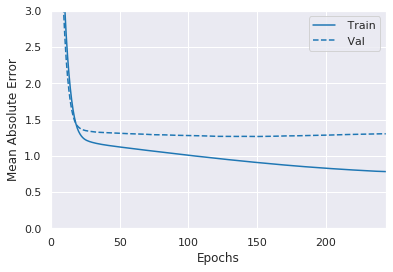

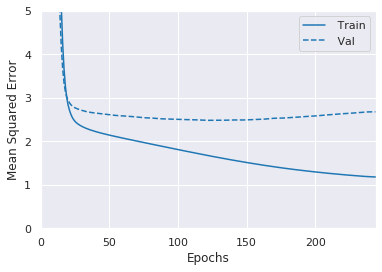

In [20]:
plt.figure()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({"": history}, metric = "mae")
plt.ylim([0, 3])
plt.ylabel('Mean Absolute Error')

plt.figure()
plotter.plot({"": history}, metric = "mse")
plt.ylim([0, 5])
plt.ylabel('Mean Squared Error')

plt.show()

## Model Validation

In [21]:
def inv_scale(y):
    ret_y = np.copy(y)
    ret_y[:, 0] = ret_y[:, 0] * 33.5
    ret_y[:, 1] = ret_y[:, 1] * 16.8
    return ret_y

def average_distance_error(preds, y_test, scaled=False):
    if scaled:
        preds = inv_scale(preds)
        y_test = inv_scale(y_test)
    return np.mean(np.sqrt(np.sum(np.square(preds - y_test), axis=1)))

In [22]:
def cdf(preds, y_test, test_data=False):
    cpin = test_pin if test_data else pin
    plt.figure(figsize=(5, 5))
    for loc in cpin.keys():
        x_selector = np.isclose(y_test[:, 0], cpin[loc]['X'], atol=0.01)
        y_selector = np.isclose(y_test[:, 1], cpin[loc]['Y'], atol=0.01)
        selector = np.logical_and(x_selector, y_selector)
        selector = selector.reshape(-1)
        Z = np.sqrt(np.sum(np.square(preds[selector] - y_test[selector]), axis=1))
        N = Z.size

        X = np.sort(Z)
        F = np.array(range(N)) / float(N)

        plt.plot(X, F, label=loc)
    plt.title('CDF of Euclidean Distance Error')
    plt.xlabel('Euclidean Distance Error (m)')
    plt.ylabel('Density')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

10311/1 - 0s - loss: 1.4378 - mae: 0.8690 - mse: 1.4246
Validation loss: 2.086521859457347
Mean absolute error: 0.86904943
Mean squared error: 1.4246122
Average distance error: 1.4200964058042342


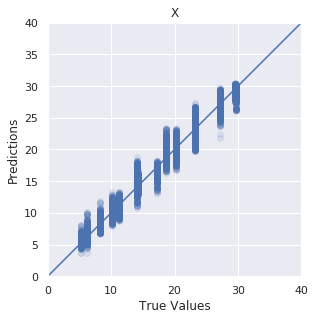

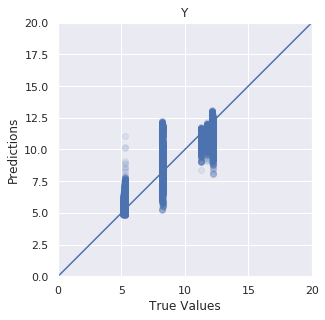

In [23]:
validation_scores = model.evaluate(X_validation, y_validation, verbose=2)
print("Validation loss:", validation_scores[0])
print("Mean absolute error:", validation_scores[1])
print("Mean squared error:", validation_scores[2])

preds = model.predict(X_validation)
print("Average distance error:", average_distance_error(preds, y_validation))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, 0], preds[:, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, 1], preds[:, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

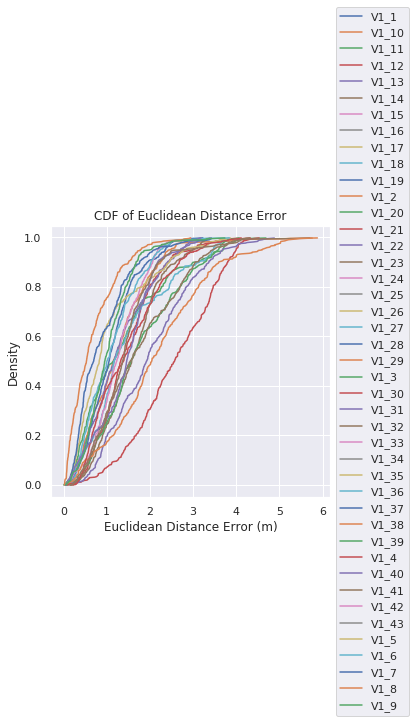

In [24]:
cdf(preds, y_validation)

## Model Testing

11680/1 - 0s - loss: 2.8084 - mae: 1.3020 - mse: 2.6815
Test loss: 3.343434129022572
Mean absolute error: 1.3020338
Mean squared error: 2.6815238
Average distance error: 2.070028117720131


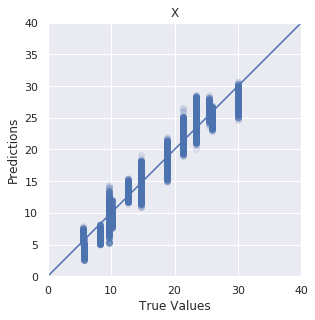

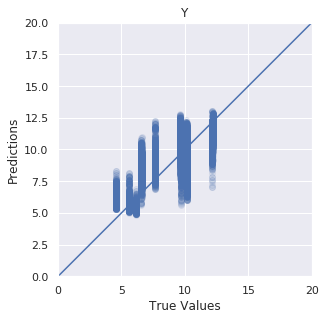

In [25]:
test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Mean absolute error:", test_scores[1])
print("Mean squared error:", test_scores[2])

preds = model.predict(X_test)
print("Average distance error:", average_distance_error(preds, y_test))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_test[:, 0], preds[:, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')

ax1.scatter(y_test[:, 1], preds[:, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

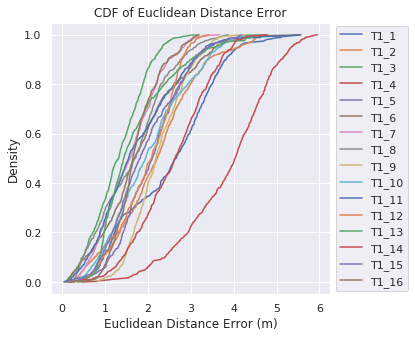

In [26]:
cdf(preds, y_test, test_data=True)

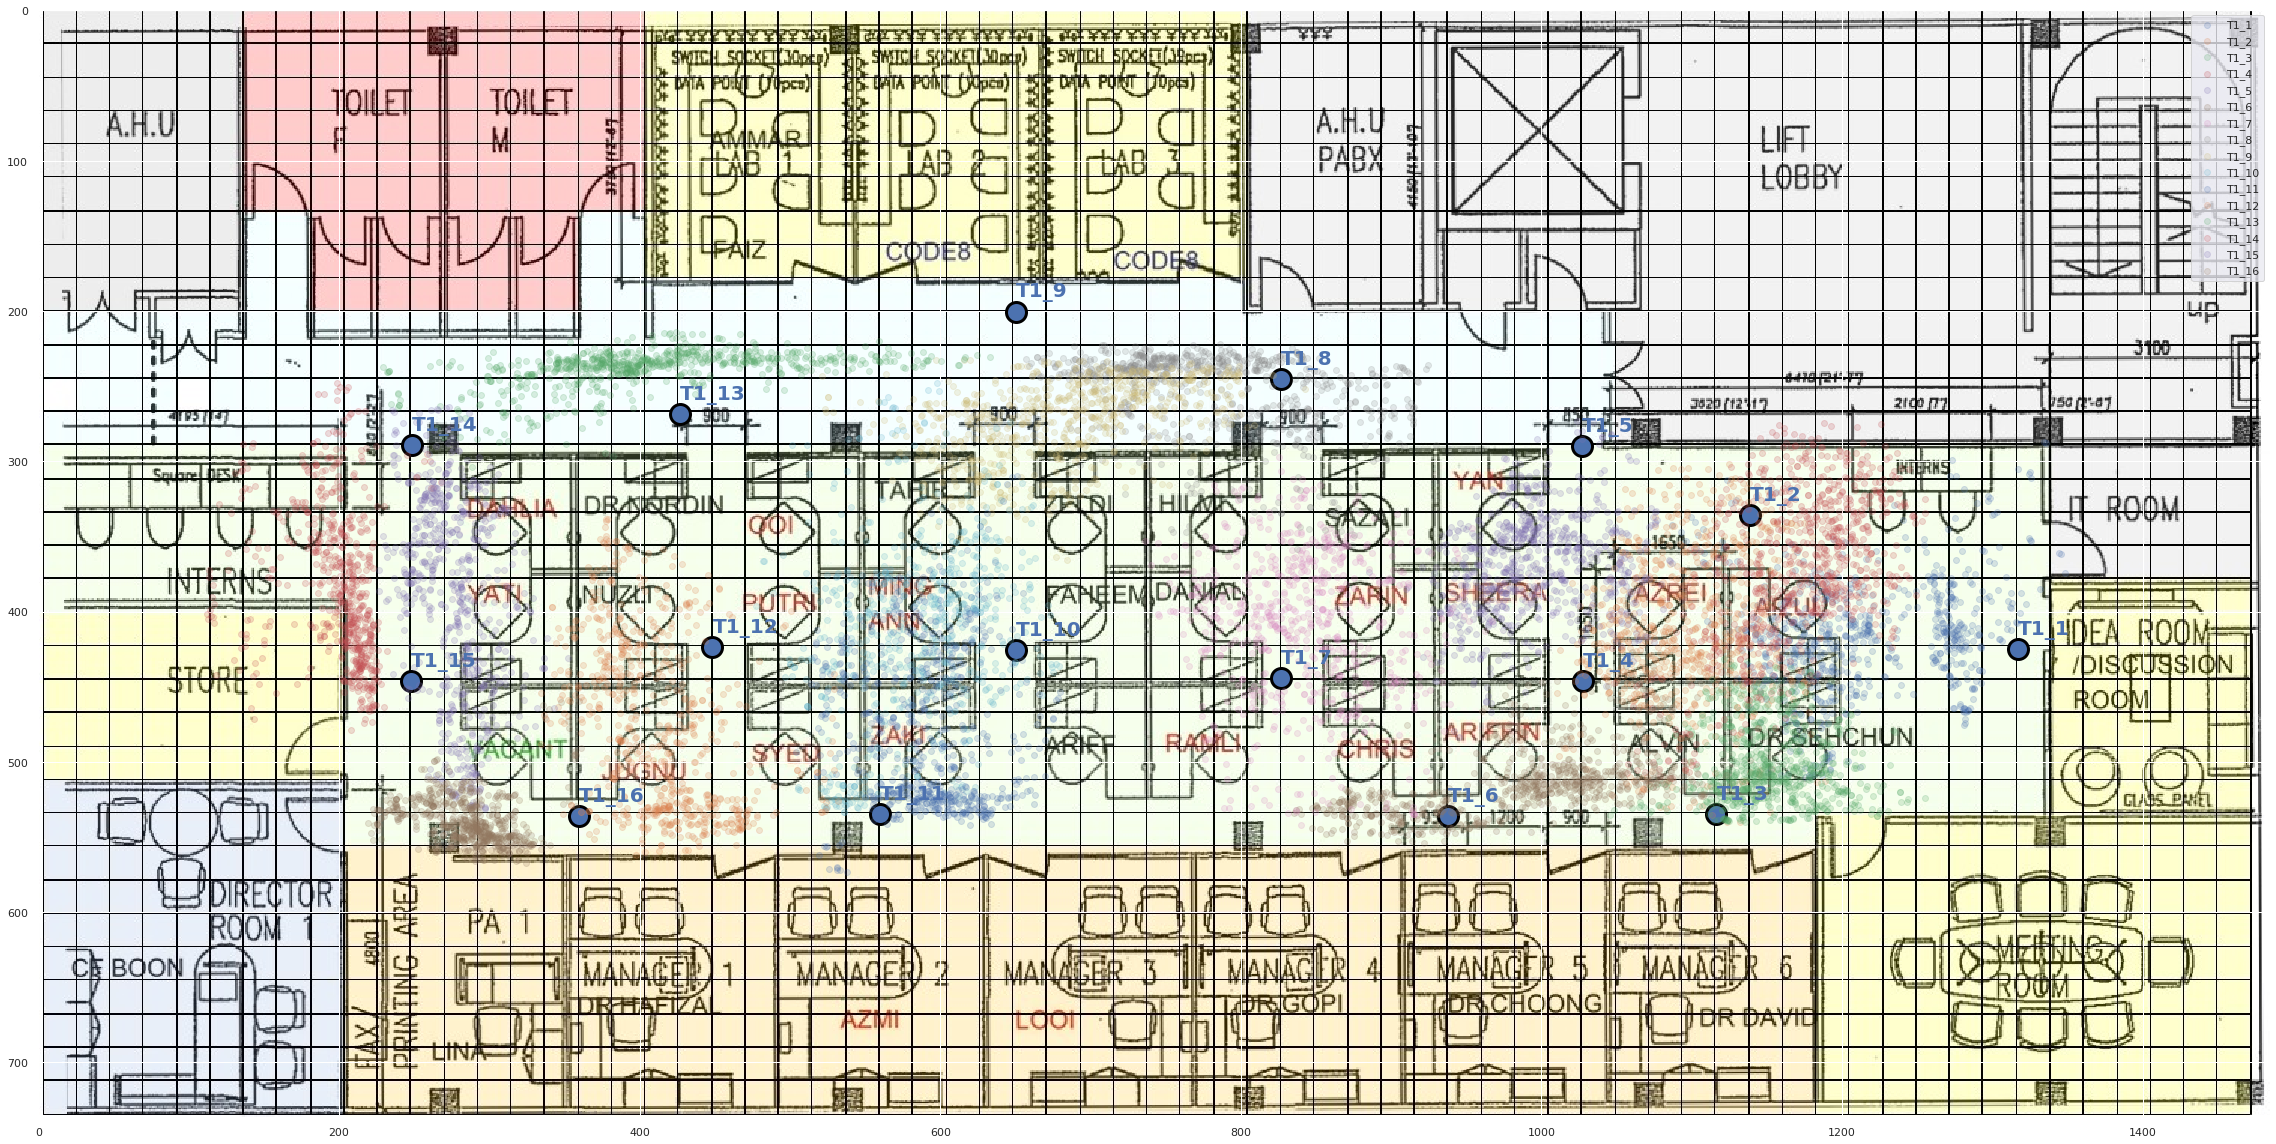

In [27]:
img =  mpimg.imread('../Map/main.png')
fingerprint_color = "r"
testdata_color = "b"
plt.figure(figsize=(40,40))
plt.imshow(img)

labels = ["V1_23", "V1_24", "V1_32", "V1_22", "V1_14", "V1_13", "V1_12", "V1_21", "V1_29", "V1_30", "V1_31", "V1_11", "V1_20", "V1_28", "V1_10", "V1_19", "V1_27", "V1_9", "V1_8", "V1_18", "V1_26"]
x = [27.151600, 29.594400, 29.689400, 23.153700, 23.169100, 20.171700, 17.173201, 18.712299, 18.691700, 23.244200, 27.133301, 14.063600, 14.159800, 14.250300, 11.176600, 10.162500, 10.141900, 8.178670, 5.180690, 6.164600, 6.255650]
y = [8.159480, 8.172020, 11.286000, 8.250140, 5.247920, 5.121330, 5.217130, 8.227330, 12.230300, 12.253700, 11.717700, 5.312350, 8.203950, 12.207500, 5.297530, 8.183420, 12.186400, 5.282130, 5.266730, 8.274090, 12.166400]
x = np.array(x) * 44
y = np.array(y) * 44

testLabels = ["T1_1", "T1_2", "T1_3", "T1_4", "T1_5", "T1_6", "T1_7", "T1_8", "T1_9", "T1_10", "T1_11", "T1_12", "T1_13", "T1_14", "T1_15", "T1_16"]
testX = [29.934250, 25.877805, 25.372470, 23.355726, 23.333564, 21.316819, 18.790348, 18.790348, 14.779021, 14.779021, 12.717952, 10.191480, 9.703916, 5.648265, 5.626103, 8.174736]
testY = [9.659024, 7.630801, 12.155781, 10.139037, 6.593112, 12.177943, 10.094712, 5.573659, 4.554205, 9.673634, 12.155781, 9.629310, 6.105547, 6.570950, 10.139037, 12.177943]
testX = np.array(testX) * 44
testY = np.array(testY) * 44

# plt.scatter(x, y, s=400, c=fingerprint_color, edgecolors="black", linewidths=3)
plt.scatter(testX, testY, s=400, c=testdata_color, edgecolors="black", linewidths=3)

# for i in range(len(labels)):
#     plt.annotate(labels[i], (x[i], y[i] - 10), fontsize=20, color=fingerprint_color, weight='bold')

for j in range(len(testLabels)):
    plt.annotate(testLabels[j], (testX[j], testY[j] - 10), fontsize=20, color=testdata_color, weight='bold')

for i in range(len(testLabels)):
    loc = testLabels[i]
    test_loc = test_imputed[test_imputed['location'] == loc]
    X_loc = test_loc[scanners].values
    locs = model.predict(X_loc) * 44
    plt.scatter(locs[:, 0], locs[:, 1], alpha=0.2, label=testLabels[i])
plt.legend()

model.save("../Models/MLP_CombineData.h5")